This notebook is the analysis supporting the paper titled  _Assessing the impact of general practice software on prescribing safety recommendations for diltiazem, tacrolimus and ciclosporin. A cohort study in English NHS primary care_



In [1]:
##import libraries neededd
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


In [2]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Part 1: Breaches in Guidance by practice/CCG

## 1a Ciclosporin and Tacrolimus

In [3]:
sql='''
SELECT
  p.month,
  practice_id,
  p.pct_id,
  numerator,
  denominator,
  calc_value,
  percentile
FROM
  `ebmdatalab.measures.practice_data_ciclosporin` AS p
INNER JOIN
  ebmdatalab.hscic.practices AS prac
ON
  p.practice_id = prac.code
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = prac.code
WHERE
  (setting = 4 
  AND denominator > 0)
GROUP BY
p.month,
practice_id,
p.pct_id,
numerator,
denominator,
calc_value,
percentile
'''

df1a = bq.cached_read(sql, csv_path='df1a.csv', use_cache=True)
df1a['month'] = pd.to_datetime(df1a['month'])
df1a.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df1a.head(5)


,month,practice_id,pct,numerator,denominator,calc_value,percentile
0,2015-02-01,A81001,00K,0,2,0.00,0.00
1,2015-03-01,A81001,00K,0,2,0.00,0.00
2,2014-11-01,A81001,00K,0,3,0.00,0.00
3,2014-12-01,A81001,00K,0,2,0.00,0.00
4,2015-01-01,A81001,00K,0,2,0.00,0.00


In [4]:
df1a2018 = df1a.loc[(df1a["month"]>= "2018-01-01") & (df1a["month"]<="2018-12-01")]
df1a2018.head(5)

,month,practice_id,pct,numerator,denominator,calc_value,percentile
6,2018-01-01,A81002,00K,0,5,0.00,0.00
7,2018-06-01,A81002,00K,0,3,0.00,0.00
16,2018-04-01,A81002,00K,0,4,0.00,0.00
18,2018-03-01,A81002,00K,0,3,0.00,0.00
20,2018-12-01,A81002,00K,0,3,0.00,0.00


In [5]:
df1a2018.describe(percentiles=(.1,.90))

,numerator,denominator,calc_value,percentile
count,49500.00,49500.00,49500.00,49500.00
mean,0.48,3.95,0.15,0.21
std,1.17,3.83,0.30,0.37
min,0.00,1.00,0.00,0.00
10%,0.00,1.00,0.00,0.00
50%,0.00,3.00,0.00,0.00
90%,2.00,8.00,0.67,0.89
max,65.00,66.00,1.00,0.93


In [6]:
df1a2018.sum(numeric_only=True)

numerator      23788.00
denominator   195283.00
calc_value      7201.04
percentile     10577.02
dtype: float64

In [7]:
#number of practices in the dataset who prescribed at least one Rx 
df1a2018.practice_id.nunique()

5439

In [8]:
#now lets restrict to values where numerator is greater than 0 i.e. some generic Rxs
breachciclo = df1a2018[df1a2018['numerator']>0]
breachciclo.head()

,month,practice_id,pct,numerator,denominator,calc_value,percentile
201218,2018-01-01,A89006,00P,1,16,0.06,0.74
201225,2018-10-01,B81062,02Y,1,16,0.06,0.75
201233,2018-04-01,B83014,02R,1,16,0.06,0.75
201235,2018-11-01,B83614,02W,1,16,0.06,0.77
201236,2018-06-01,B83614,02W,1,16,0.06,0.76


In [9]:
#the number of practices that breached the ciclosporin/tacrolimus in 2018 
breachciclo.practice_id.nunique()

2241

In [10]:
##calculate proprotion that breached
breachciclo.practice_id.nunique()/df1a2018.practice_id.nunique()*100

41.20242691671263

In [11]:
###here we group for the map
by_pct_df1a = df1a[df1a['month'] == "2019-05-01"].groupby('pct').sum().reset_index()
by_pct_df1a['calc_value'] = by_pct_df1a['numerator'] / by_pct_df1a['denominator'] ##reclaculate the "calc value" as the groupby summed it
by_pct_df1a.head(5)


,pct,numerator,denominator,calc_value,percentile
0,00C,0,28,0.00,0.00
1,00D,11,149,0.07,2.66
2,00J,5,118,0.04,2.48
3,00K,3,39,0.08,2.63
4,00L,0,88,0.00,0.00


### 1b Diltiazem

In [12]:
sql='''
SELECT
  p.month,
  practice_id,
  p.pct_id,
  numerator,
  denominator,
  calc_value,
  percentile
FROM
  ebmdatalab.measures.practice_data_diltiazem AS p
INNER JOIN
  ebmdatalab.hscic.practices AS prac
ON
  p.practice_id = prac.code
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = prac.code
WHERE
  (setting = 4  ##need to add prac = 4 here
    AND denominator > 0)
GROUP BY
  p.month,
  practice_id,
  p.pct_id,
  numerator,
  denominator,
  calc_value,
  percentile
'''

df1b = bq.cached_read(sql, csv_path='diltiazem.csv', use_cache=True)
df1b['month'] = pd.to_datetime(df1b['month'])
df1b.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df1b.head(5)

,month,practice_id,pct,numerator,denominator,calc_value,percentile
0,2016-03-01,A81001,00K,3,16,0.19,0.65
1,2016-06-01,A81001,00K,1,13,0.08,0.45
2,2016-01-01,A81002,00K,2,87,0.02,0.31
3,2018-11-01,A81002,00K,2,86,0.02,0.36
4,2015-09-01,A81002,00K,7,96,0.07,0.42


In [13]:
df1b2018 = df1b.loc[(df1b["month"]>= "2018-01-01") & (df1b["month"]<="2018-12-01")]
df1b2018.head(5)

,month,practice_id,pct,numerator,denominator,calc_value,percentile
3,2018-11-01,A81002,00K,2,86,0.02,0.36
5,2018-06-01,A81002,00K,5,85,0.06,0.45
6,2018-04-01,A81002,00K,2,79,0.03,0.37
8,2018-09-01,A81002,00K,4,86,0.05,0.43
11,2018-12-01,A81002,00K,5,106,0.05,0.43


In [14]:
df1b2018.describe(percentiles=(.1,.90))

,numerator,denominator,calc_value,percentile
count,83788.00,83788.00,83788.00,83788.00
mean,3.49,28.41,0.16,0.44
std,5.50,27.81,0.22,0.35
min,0.00,1.00,0.00,0.00
10%,0.00,5.00,0.00,0.00
50%,2.00,21.00,0.08,0.50
90%,9.00,60.00,0.47,0.90
max,118.00,384.00,1.00,0.99


In [15]:
df1b2018.sum(numeric_only=True)

numerator      292331.00
denominator   2380128.00
calc_value      13559.86
percentile      37239.01
dtype: float64

In [16]:
#number of practices in the dataset who prescribed at least one Rx and have a list size >1000?
df1b2018.practice_id.nunique()

7186

In [17]:
#now lets restrict to values where numerator is greater than 0 i.e. some generic Rxs
breachdilt = df1b2018[df1b2018['numerator']>0]
breachdilt.head()

,month,practice_id,pct,numerator,denominator,calc_value,percentile
3,2018-11-01,A81002,00K,2,86,0.02,0.36
5,2018-06-01,A81002,00K,5,85,0.06,0.45
6,2018-04-01,A81002,00K,2,79,0.03,0.37
8,2018-09-01,A81002,00K,4,86,0.05,0.43
11,2018-12-01,A81002,00K,5,106,0.05,0.43


In [18]:
#the number of practices that breached the diltiazem in 2018 
breachdilt.practice_id.nunique()

5777

In [19]:
#calulate proportion of practices that breached
breachdilt.practice_id.nunique()/df1b2018.practice_id.nunique()*100

80.39242972446424

In [20]:
### here we calculate totals on both measures
total = df1a2018.sum(numeric_only=True) +df1b2018.sum(numeric_only=True)
total

numerator      316119.00
denominator   2575411.00
calc_value      20760.90
percentile      47816.03
dtype: float64

In [21]:
## calculate proprotion of scrips in numerator from total prescritpions
(total['numerator'] / total['denominator'])*100

12.27450686511784

In [22]:
###here we group for the map
by_pct_df1b = df1b[df1b['month'] == "2019-05-01"].groupby('pct').sum().reset_index()
by_pct_df1b['calc_value'] = by_pct_df1b['numerator'] / by_pct_df1b['denominator'] ##reclaculate the "calc value" as the groupby summed it
by_pct_df1b.head(5)

,pct,numerator,denominator,calc_value,percentile
0,00C,2,386,0.01,0.45
1,00D,82,1746,0.05,8.76
2,00J,74,1197,0.06,11.04
3,00K,69,1645,0.04,11.04
4,00L,80,2433,0.03,9.66


# Part 2: EHR Work

In [23]:
##Importing GP EHR Deployment Data
###this will need cleaning up? Seb/ALex?
vendors = pd.read_csv(r'C:\Users\bmackenna\Documents\GitHub\jupyter-notebooks\measures_by_software\vendors.csv')
# Clean up the input data
vendors['Principal Supplier'] = vendors['Principal Supplier'].str.strip()
vendors.loc[vendors['Principal Supplier'] == 'INPS', 'Principal Supplier'] = 'Vision'  # seems they changed in 2017
vendors = vendors.loc[vendors['Date'] > '2016-02-01']  # there is some dirty data ("Unknowns") before this

start = pd.to_datetime('2016-01-01')
mid = pd.to_datetime('2017-01-01')
end = pd.to_datetime('2018-12-01')

## 2a ciclosporin and tacrolimus measure data linked to EHR provider

In [24]:
import importlib
importlib.reload(bq)
measures = ['ciclosporin']

def get_data(measure_id):
    sql = """
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.practice_id,
  m.pct_id,
  Date as month,
  numerator,
  denominator,
  '{measure_id}' AS measure_id
FROM
  measures.practice_data_{measure_id} as m
JOIN
  ebmdatalab.alex.vendors as software #this is where the up to date vendors table is held
ON
  software.ODS = practice_id
  AND DATE(Date) = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = practice_statistics.month
WHERE
total_list_size > 100
  AND practices.status_code = 'A'
  AND denominator > 0
  AND m.month <= "2019-05-01"
ORDER BY
  m.month""".format(measure_id=measure_id)
    import pandas as pd
    df = bq.cached_read(sql, csv_path="ciclosporintacro.csv".format(measure_id))
    return df


df2a = get_data('ciclosporin')
df2a = df2a.replace(['TPP'],'SystmOne')
df2a = df2a.replace(['INPS'],'Vision')
df2a.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df2a.head(5)

,supplier,practice_id,pct,month,numerator,denominator,measure_id
0,SystmOne,A81002,00K,2016-01-01,0,5,ciclosporin
1,SystmOne,A81004,00M,2016-01-01,0,6,ciclosporin
2,SystmOne,A81005,00M,2016-01-01,0,1,ciclosporin
3,SystmOne,A81006,00K,2016-01-01,0,3,ciclosporin
4,EMIS,A81007,00K,2016-01-01,0,1,ciclosporin


In [25]:
df2a['calc_value'] = df2a['numerator'] / df2a['denominator']
df2a['month'] = pd.to_datetime(df2a['month'])

Text(0, 0.5, 'proportion')

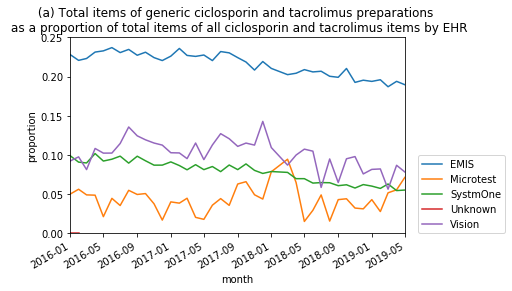

In [26]:
ax = df2a.groupby(['month', 'supplier']).mean()['calc_value'].unstack().plot.line()
plt.ylim(0, 0.25)
plt.legend(loc=(1.04,0))
plt.title(" (a) Total items of generic ciclosporin and tacrolimus preparations  \n as a proportion of total items of all ciclosporin and tacrolimus items by EHR"),
ax.set_ylabel("proportion")

In [27]:
dfccg = df2a.groupby(['month','pct']).sum().reset_index()
dfccg.head(5)

,month,pct,numerator,denominator,calc_value
0,2016-01-01,00C,2,47,0.37
1,2016-01-01,00D,10,194,2.87
2,2016-01-01,00J,19,177,3.33
3,2016-01-01,00K,14,77,2.88
4,2016-01-01,00L,1,174,1.00


### 2b - Diltiazem linked with EHR

In [28]:
importlib.reload(bq)
measures = ['diltiazem']

def get_data(measure_id):
    sql = """
SELECT
  TRIM(Principal_Supplier) AS supplier,
  m.practice_id,
  m.pct_id,
  Date as month,
  numerator,
  denominator,
  '{measure_id}' AS measure_id
FROM
  measures.practice_data_{measure_id} as m
JOIN
  ebmdatalab.alex.vendors as software #this is where the up to date vendors table is held
ON
  software.ODS = practice_id
  AND DATE(Date) = m.month
JOIN
  hscic.practices
ON
  practices.code = software.ODS
JOIN
  hscic.practice_statistics
ON
  practice_statistics.practice = practices.code
  AND Date = practice_statistics.month
WHERE
total_list_size > 100
  AND practices.status_code = 'A'
  AND denominator > 0
  AND m.month <= "2019-05-01"
ORDER BY
  m.month""".format(measure_id=measure_id)
    import pandas as pd
    df2 = bq.cached_read(sql, csv_path="diltiazem.csv".format(measure_id))
    return df2


df2b = get_data('diltiazem')
df2b = df2b.replace(['TPP'],'SystmOne')
df2b = df2b.replace(['INPS'],'Vision')
df2b.rename(columns={'pct_id':'pct'}, inplace=True) ##prep for maps library whe  pct must be colum name
df2b.head(5)

,supplier,practice_id,pct,month,numerator,denominator,measure_id
0,SystmOne,A81002,00K,2016-01-01,2,87,diltiazem
1,SystmOne,A81006,00K,2016-01-01,3,103,diltiazem
2,EMIS,A81007,00K,2016-01-01,14,109,diltiazem
3,SystmOne,A81009,00M,2016-01-01,3,44,diltiazem
4,SystmOne,A81012,00M,2016-01-01,1,14,diltiazem


In [29]:
df2b['calc_value'] = df2b['numerator'] / df2b['denominator']
df2b['month'] = pd.to_datetime(df2b['month'])

In [30]:
df2b.month.nunique

<bound method IndexOpsMixin.nunique of 0        2016-01-01
1        2016-01-01
2        2016-01-01
3        2016-01-01
4        2016-01-01
            ...    
266252   2019-05-01
266253   2019-05-01
266254   2019-05-01
266255   2019-05-01
266256   2019-05-01
Name: month, Length: 266257, dtype: datetime64[ns]>

Text(0, 0.5, 'proportion')

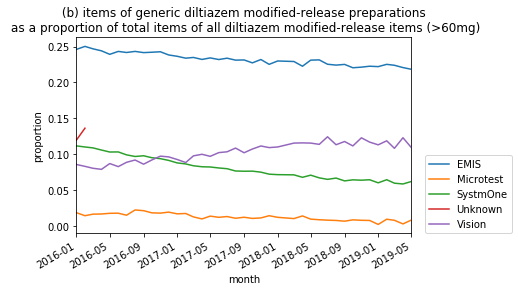

In [31]:
ax1 = df2b.groupby(['month', 'supplier']).mean()['calc_value'].unstack().plot.line()
plt.legend(loc=(1.04,0))
plt.title(" (b) items of generic diltiazem modified-release preparations \n as a proportion of total items of all diltiazem modified-release items (>60mg)")
ax1.set_ylabel("proportion")

In [32]:
df2b.rename(columns={'pct_id':'pct'}, inplace=True)  # The CCG column must be named 'pct' for the maps function
by_supplier_and_pct = df2b.groupby(['supplier', 'pct']).sum().reset_index()
by_supplier_and_pct['calc_value'] = by_supplier_and_pct['numerator'] / by_supplier_and_pct['denominator']

In [33]:
epr_dec18 = df2b.loc[df2b['month']=='2018-12-01',['practice_id','supplier']]
epr_dec18.head(5)

,practice_id,supplier
226267,A81002,SystmOne
226268,A81006,SystmOne
226269,A81007,EMIS
226270,A81009,SystmOne
226271,A81013,SystmOne


In [34]:
## here we asess EHR deployment in 2018
ehr_deployment = epr_dec18.groupby('supplier').count()
ehr_deployment.head()

,practice_id
supplier,
EMIS,3888
Microtest,46
SystmOne,2448
Vision,283


Ghost Branded Generics can cause prescribing of brands to be "hidden" in prescribing data. We have written about it [extensively on our blog](https://ebmdatalab.net/ghost-branded-generics-why-does-the-cost-of-generic-atorvastatin-vary%EF%BB%BF/). Here we will check how many prescriptions could have been affected. 

In [35]:
sql= '''
SELECT
  DATE(month) AS month,
  pct,
  practice,
  SUM(CASE
      WHEN (possible_savings >= 2 OR possible_savings <=-2) THEN items
    ELSE
    0
  END
    ) AS items
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper_2019_07
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
WHERE
bnf_code LIKE '0802020G0%' OR ##Ciclosporin (Systemic) 
bnf_code LIKE '0802020T0%'  ##Tacrolimus (Systemic) 
GROUP BY
  month,
  pct,
  practice'''

df1a_gbg = bq.cached_read(sql, csv_path='gbg.tacro.ciclo.zip',use_cache=True)
df1a_gbg.head(5)

,month,pct,practice,items
0,2016-03-01,06F,E81003,0
1,2016-03-01,06H,D81625,0
2,2016-03-01,07M,E83621,0
3,2016-02-01,04C,C82008,0
4,2016-02-01,15E,M85127,0


In [36]:
df1a_gbg.sum(numeric_only = True)

items    3605
dtype: int64

In [37]:
df1a_gbg.loc[(df1a_gbg["month"]>= "2018-01-01") & (df1a_gbg["month"]<="2018-12-01")].sum(numeric_only = True)

items    18
dtype: int64

In [38]:
sql= '''
SELECT
  DATE(month) AS month,
  pct,
  practice,
  SUM(CASE
      WHEN (possible_savings >= 2 OR possible_savings <=-2) THEN items
    ELSE
    0
  END
    ) AS items
FROM
  ebmdatalab.alex.vw__ghost_generic_measure_paper_2019_07
INNER JOIN
  ebmdatalab.hscic.practices
ON
  practice = code
  AND setting = 4
WHERE
  bnf_code LIKE '0206020C0%AB' OR --Diltiazem HCl_Tab 120mg C/R
  bnf_code LIKE '0206020C0%AC' OR --Diltiazem HCl_Tab 90mg M/R 
  bnf_code LIKE '0206020C0%AD' OR --Diltiazem HCl_Tab 120mg S/R 
  bnf_code LIKE '0206020C0%AE' OR --Diltiazem HCl_Cap 300mg M/R 
  bnf_code LIKE '0206020C0%AF' OR --Diltiazem HCl_Cap 90mg C/R 
  bnf_code LIKE '0206020C0%AG' OR --Diltiazem HCl_Cap 180mg C/R 
  bnf_code LIKE '0206020C0%AH' OR --Diltiazem HCl_Cap 300mg C/R 
  bnf_code LIKE '0206020C0%AI' OR --Diltiazem HCl_Cap 120mg C/R 
  bnf_code LIKE '0206020C0%AK' OR --Diltiazem HCl_Cap 90mg S/R 
  bnf_code LIKE '0206020C0%AL' OR --Diltiazem HCl_Cap 120mg S/R 
  bnf_code LIKE '0206020C0%AM' OR --Diltiazem HCl_Cap 240mg C/R 
  bnf_code LIKE '0206020C0%AN' OR --Diltiazem HCl_Cap 180mg S/R 
  bnf_code LIKE '0206020C0%AP' OR --Diltiazem HCl_Cap 240mg S/R 
  bnf_code LIKE '0206020C0%AS' OR --Diltiazem HCl_Tab 120mg M/R 
  bnf_code LIKE '0206020C0%AT' OR --Diltiazem HCl_Cap 90mg M/R 
  bnf_code LIKE '0206020C0%AU' OR --Diltiazem HCl_Cap 120mg M/R 
  bnf_code LIKE '0206020C0%AV' OR --Diltiazem HCl_Cap 180mg M/R 
  bnf_code LIKE '0206020C0%AW' OR --Diltiazem HCl_Cap 240mg M/R 
  bnf_code LIKE '0206020C0%AX' OR --Diltiazem HCl_Cap 200mg M/R 
  bnf_code LIKE '0206020C0%AY' OR --Diltiazem HCl_Cap 240mg M/R 
  bnf_code LIKE '0206020C0%BA' --Diltiazem HCl_Cap 360mg M/R 
GROUP BY
  month,
  pct,
  practice'''

df1b_gbg = bq.cached_read(sql, csv_path='gbg.diltiazem.zip',use_cache=True)
df1b_gbg.head(5)

,month,pct,practice,items
0,2014-03-01,12F,N85016,0
1,2014-03-01,02F,N81081,0
2,2014-03-01,07T,F84719,0
3,2014-03-01,15E,M85045,0
4,2014-03-01,00X,P81082,0


In [39]:
df1b_gbg.sum(numeric_only=True)

items    2965
dtype: int64

In [40]:
df1b_gbg.loc[(df1b_gbg["month"]>= "2018-01-01") & (df1b_gbg["month"]<="2018-12-01")].sum(numeric_only = True)

items    59
dtype: int64

 GBG does not appear to be a signifcant issue with these preparations. Cross referencing with dmd there does not apear to be AMPP that would cause this issue. [see diltiazem](https://openprescribing.net/dmd/?q=diltiazem&obj_types=ampp&submit=Search). GBGs appears to only be an issue with Diltiazem = 60mg